# Simple 2D Planewave Absorption Bound Example using dolphindes

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import sys, time
sys.path.append("/home/pengning/Documents/Research/DolphinDes_Dev/dolphindes")

from dolphindes.photonics.photonics import Photonics_TM_FDFD

In [2]:
wvlgth = 1.0
omega = 2 * np.pi / wvlgth
prob = Photonics_TM_FDFD(omega)
print(prob)
print('chi_background', prob.chi_background)

chi_background None


In [3]:
## geometry and materials of the planewave absorption problem ##
prob.chi = 3+1e-2j
gpr = 40
prob.dl = 1.0 / gpr

des_x = des_y = 1.0
pmlsep = pmlthick = 0.5
Mx = int(des_x * gpr)
My = int(des_y * gpr)

Npmlsepx = Npmlsepy = int(pmlsep * gpr)
Npmlx = Npmly = int(pmlthick * gpr)
Nx = Mx + 2*(Npmlsepx + Npmlx)
Ny = My + 2*(Npmlsepy + Npmly)

prob.des_mask = np.zeros((Nx,Ny), dtype=bool)
prob.des_mask[Npmlx+Npmlsepx:-(Npmlx+Npmlsepx) , Npmly+Npmlsepy:-(Npmly+Npmlsepy)] = True
Ndes = int(np.sum(prob.des_mask))

In [4]:
## setup FDFD solver ##
prob.setup_FDFD(Nx=Nx, Ny=Ny, Npmlx=Npmlx, Npmly=Npmly)
print(prob.FDFD)

In [5]:
## setup up QCQP for planewave absorption ##
prob.sparseQCQP = True
print('chibackground', prob.chi_background)
prob.setup_EM_operators()

prob.ji = np.zeros((Nx,Ny), dtype=complex)
#prob.ji[:,Npmly] = 2.0 / prob.dl # planewave line source traveling in y dir
prob.ji[Npmlx,:] = 2.0 / prob.dl # planewave line source traveling in x dir

prob.c0 = 0.0
prob.s0 = np.zeros(Ndes, dtype=complex)
prob.A0 = 0.5 * np.imag(1/prob.chi) * omega * prob.Ginv.conj().T @ prob.Ginv * prob.dl**2


chibackground None


In [6]:
prob.setup_QCQP(Pdiags="global")
print(prob.QCQP)

/home/pengning/Documents/Research/DolphinDes_Dev/dolphindes/dolphindes/cvxopt/qcqp.py:115: CholmodTypeConversionWarning: converting matrix of class csr_array to CSC format
  self.Achofac = sksparse.cholmod.analyze(A)
/home/pengning/Documents/Research/DolphinDes_Dev/dolphindes/dolphindes/cvxopt/qcqp.py:115: CholmodTypeConversionWarning: converting matrix of class csc_array to CSC format
  self.Achofac = sksparse.cholmod.analyze(A)


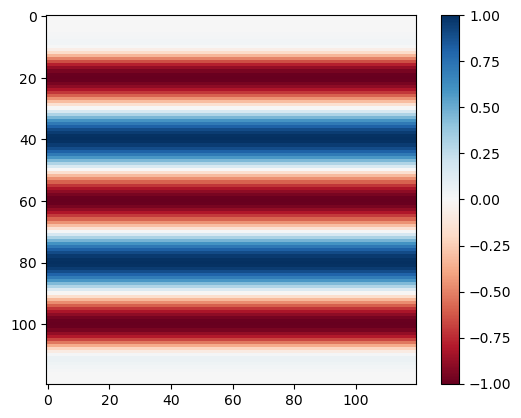

In [7]:
## plot ei as a result of the given ji ##
plt.imshow(np.real(prob.ei), cmap='RdBu')
plt.colorbar()

In [8]:
### timing of get_dual on its own ###
import timeit
init_lags = np.array([0, 0.01])
timeit.timeit(lambda: prob.QCQP.get_dual(init_lags, get_grad=False), number=500) / 500

/home/pengning/Documents/Research/DolphinDes_Dev/dolphindes/dolphindes/cvxopt/qcqp.py:136: CholmodTypeConversionWarning: converting matrix of class csr_array to CSC format
  Acho = self.Achofac.cholesky(A)


0.018467669206002027

In [9]:
## solve for global dual bound ##
opt_params = {'opttol':1e-2, 'gradConverge': False, 'min_inner_iter': 5, 'max_restart': np.inf, 'penalty_ratio': 1e-2, 'penalty_reduction': 0.1, 'break_iter_period': 20, 'verbose': 1, 'penalty_vector_list': []}
t = time.time()
init_lags = np.array([0, 0.01])
prob.QCQP.solve_current_dual_problem(method="bfgs", opt_params=opt_params, init_lags = init_lags)
print('time took', time.time() - t) ## around 23 s on my machine

Optimizer initialized with parameters:
opttol: 0.01
gradConverge: False
min_inner_iter: 5
max_restart: inf
penalty_ratio: 0.01
penalty_reduction: 0.1
break_iter_period: 20
verbose: 1
penalty_vector_list: []
Starting optimization with x0 = [0.   0.01]
Outer iteration 0, penalty_ratio = 0.01, opt_fx = 5.0390162763191615


/home/pengning/Documents/Research/DolphinDes_Dev/dolphindes/dolphindes/cvxopt/qcqp.py:264: CholmodTypeConversionWarning: converting matrix of class csr_array to CSC format
  Acho = self.Achofac.cholesky(A)


iter_num: 20, prev_fx: inf, opt_fx: 2.478893065374969, opttol: 0.01
iter_num: 40, prev_fx: 2.478893065374969, opt_fx: 2.4788697918767255, opttol: 0.01
Outer iteration 1, penalty_ratio = 0.001, opt_fx = 1.5424328736292057
iter_num: 20, prev_fx: 2.478893065374969, opt_fx: 1.1858671531731426, opttol: 0.01
iter_num: 40, prev_fx: 1.1858671531731426, opt_fx: 1.170646436184425, opttol: 0.01
iter_num: 60, prev_fx: 1.170646436184425, opt_fx: 1.1706464360922175, opttol: 0.01
Outer iteration 2, penalty_ratio = 0.0001, opt_fx = 1.168943869229361
time took 14.749622344970703


In [10]:
print(prob.QCQP.current_dual)

1.1689149713063332


## comparison with old photonic-dual-bounds code

In [11]:
sys.path.append('/home/pengning/Documents/Research/Github_photonic-dual-bounds/photonic-dual-bounds')
from dualbound.Lagrangian.spatialProjopt_Zops_Msparse import Cholesky_analyze_ZTT, get_multiSource_Msparse_gradZTS_S, get_Msparse_gradZTS_S, get_multiSource_Msparse_gradZTT, get_Msparse_gradZTT, get_Msparse_inc_ZTT_mineig, get_Msparse_inc_PD_ZTT_mineig, check_Msparse_spatialProj_Lags_validity, check_Msparse_spatialProj_incLags_validity

from dualbound.Lagrangian.spatialProjopt_vecs_Msparse import get_ZTTcho_Tvec

from dualbound.Lagrangian.spatialProjopt_dualgradHess_fakeS_Msparse import get_inc_spatialProj_dualgrad_fakeS_Msparse, get_inc_spatialProj_dualgradHess_fakeS_Msparse

from dualbound.Lagrangian.spatialProjopt_feasiblept_Msparse import spatialProjopt_find_feasiblept 

from dualbound.Optimization.BFGS_fakeSource_with_restart import BFGS_fakeS_with_restart

from dualbound.Optimization.fakeSource_with_restart_singlematrix import fakeS_with_restart_singlematrix


In [12]:
Si = prob.ei[prob.des_mask]

O_lin = prob.s0
O_quad = prob.A0

GinvdagPdaglist = [prob.Ginv.conj().T]
UPlist = [(prob.Ginv.conj().T @ prob.Ginv) / np.conj(prob.chi)  - prob.Ginv]

gradZTT = get_Msparse_gradZTT(UPlist)
ZTTchofac = Cholesky_analyze_ZTT(O_quad, gradZTT)
gradZTS_S = get_Msparse_gradZTS_S(Si, GinvdagPdaglist)

validityfunc = lambda dof: check_Msparse_spatialProj_incLags_validity(dof, include, O_quad, gradZTT, chofac=ZTTchofac)

#mineigfunc = lambda dof: get_Msparse_inc_ZTT_mineig(dof, include, O_quad, UPlist, eigvals_only=False)
mineigfunc = lambda dof: get_Msparse_inc_PD_ZTT_mineig(dof, include, O_quad, gradZTT, eigvals_only=False)

Lags = np.array([0, 0.01])
include = [True,True]
while True:
    tmp = check_Msparse_spatialProj_Lags_validity(Lags, O_quad, gradZTT)
    if tmp>0:
        break
    print(tmp, flush=True)
    print('zeta', Lags[1])
    Lags[1] *= 1.5

print('Lags', Lags)

analyzing ZTT of format and shape csr (1600, 1600) and # of nonzero elements 88816
Lags [0.   0.01]


/home/pengning/Documents/Research/Github_photonic-dual-bounds/photonic-dual-bounds/dualbound/Lagrangian/spatialProjopt_Zops_Msparse.py:128: CholmodTypeConversionWarning: converting matrix of class csr_array to CSC format
  return chol.analyze(ZTT)
/home/pengning/Documents/Research/Github_photonic-dual-bounds/photonic-dual-bounds/dualbound/Lagrangian/spatialProjopt_Zops_Msparse.py:128: CholmodTypeConversionWarning: converting matrix of class csc_array to CSC format
  return chol.analyze(ZTT)
/home/pengning/Documents/Research/Github_photonic-dual-bounds/photonic-dual-bounds/dualbound/Lagrangian/spatialProjopt_Zops_Msparse.py:194: CholmodTypeConversionWarning: converting matrix of class csr_array to CSC format
  ZTTcho = chol.cholesky(ZTT)
/home/pengning/Documents/Research/Github_photonic-dual-bounds/photonic-dual-bounds/dualbound/Lagrangian/spatialProjopt_Zops_Msparse.py:194: CholmodTypeConversionWarning: converting matrix of class csc_array to CSC format
  ZTTcho = chol.cholesky(ZTT)


In [13]:
alg='LBFGS'
dualconst=0.0
getT=False
opttol=1e-2
fakeSratio=1e-2
reductFactor=0.1
iter_period=20
t = time.time()
if alg=='Newton':
    dgHfunc = lambda dof, dofgrad, dofHess, fSl, get_grad=True, get_Hess=True: get_inc_spatialProj_dualgradHess_fakeS_Msparse(dof, dofgrad, dofHess, include, O_lin, O_quad, gradZTS_S, gradZTT, fSl, dualconst=dualconst, get_grad=get_grad, get_Hess=get_Hess, chofac=ZTTchofac)
    optincLags, optincgrad, dualval, objval = fakeS_with_restart_singlematrix(Lags[include], dgHfunc, validityfunc, mineigfunc, opttol=opttol, fakeSratio=fakeSratio, reductFactor=reductFactor, iter_period=iter_period)
elif alg=='LBFGS':
    dgfunc = lambda dof, dofgrad, fSl, get_grad=True: get_inc_spatialProj_dualgrad_fakeS_Msparse(dof, dofgrad, include, O_lin, O_quad, gradZTS_S, gradZTT, fSl, dualconst=dualconst, get_grad=get_grad, chofac=ZTTchofac)
    ### timing of dgfunc on its own ###
    init_grad = np.array([0.0,0.0])
    print( timeit.timeit(lambda: dgfunc(init_lags, init_grad, [], get_grad=False), number=500) / 500 )
    #optincLags, optincgrad, dualval, objval = BFGS_fakeS_with_restart(Lags[include], dgfunc, validityfunc, mineigfunc, opttol=opttol, fakeSratio=fakeSratio, reductFactor=reductFactor, iter_period=iter_period)

print('time took', time.time() - t) # around 4-5 s on my machine

/home/pengning/Documents/Research/Github_photonic-dual-bounds/photonic-dual-bounds/dualbound/Lagrangian/spatialProjopt_vecs_Msparse.py:27: CholmodTypeConversionWarning: converting matrix of class csr_array to CSC format
  ZTTcho = chofac.cholesky(ZTT)


0.006730257311995956
time took 3.365644931793213
